### Simulated Annealing --- solve multiple variable function optimization problem

#### target function
$$ min f(X) $$

#### Constrained
$$ c_i(X) <= 0 $$

#### convert to
$$ min L_k(X)=f(X)+\alpha_k \sum_{i}g(c_i(X)) $$
$$ g(c_i(X))=max(0, c_i(X))^2 $$

#### A factor produces two kind of drinks, each handred boxes of  JIA requires 6kg materials and 10 workers with a profit of 100000yuan. Each handred boxes of YI requires 5kg materials and 20 workers, with profit of 90000yuan.
#### The factor has 60kg of meterials and 150 workers. The quantity  of JIA is limited to 8 handred cases.
#### How to arange the production?

$$ max f(X)=10x_1 + 9x_2 $$
$$ 6x_1 + 5x_2 <= 60 $$
$$ 10x_1 + 20x_2 <= 150 $$
$$ 0 <= x_1 <= 8, 0 <= x_2 $$

#### add Penalty function
$$ P_1(X) = (max(0, 6x_1 + 5x_2 - 60))^2  $$
$$ P_2(X) = (max(0, 10x_1 + 20x_2 - 60 - 150))^2  $$
$$ P(X) = P_1(X) + P_2(X) $$
$$ L(X, m(k)) = min(f(X) + m(k) * P(X)) $$

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import math

In [2]:
class SimulatedAnnealing():
    """
    apply for simulated annealing algorithm of multiple variable function optimization problem
    """

    def __init__(self, var_num, var_min, var_max, temp_init, temp_final, markov,
                 alpha, lr, lr_decay_fac=0.99, penalty_factor=1):

        self.var_num = var_num                                  # number of variable
        self.var_min = [var_min for _ in range(var_num)]        # lower limit of search space
        self.var_max = [var_max for _ in range(var_num)]        # higher limit of search space
        self.temp_init = temp_init                              # initial temperature
        self.temp_final = temp_final                            # final temperature
        self.markov  = markov                                   # length of markov
        self.alpha = alpha                                      # cooling parameter
        self.lr = lr                                            # length of search step

        self.fx_best = None                                     # best solution
        self.X_best = None                                      # best solution

        self.temp_ = []                                         # process of temperature
        self.fx_ = []                                           # process of function value
        self.fx_best_ = []                                      # process of the best function value
        self.P_inferior_acc_ = []                               # process of inferior acceptation probability

        self.lr_decay_fac = lr_decay_fac                        # lr decay factor

        self.penalty_factor = penalty_factor                    # penalty function factor

    def func(self, X):
        """
        define the target function with penalty
        """
        p1 = math.pow((max(0, 6 * X[0] + 5 * X[1] - 60)), 2)
        p2 = math.pow((max(0, 10 * X[0] + 20 * X[1] - 150)), 2)
        fx = -(10 * X[0] + 9 * X[1]) + self.penalty_factor * (p1 + p2)
        return fx

    def lr_decay(self):
        self.lr = self.lr_decay_fac * self.lr

    def solve(self, rand_seed=None):

        if rand_seed != None:
            random.seed(rand_seed)

        # --- random initialize the solution --- #

        X_init = np.zeros((self.var_num))
        for i in range(self.var_num):
            X_init[i] = random.uniform(self.var_min[i], self.var_max[i])

        # --- initialize --- #

        fx_init = self.func(X_init)
        fx_curr = fx_init
        self.fx_best = fx_init
        print('initial function value is:', fx_init)

        X_curr = copy.deepcopy(X_init)
        temp_curr = self.temp_init

        # --- solve --- #

        itr = 0
        while temp_curr >= self.temp_final:

            high_quality_num = 0
            inferior_acc_num = 0
            inferior_ref_num = 0

            self.penalty_factor = itr + 1

            for _ in range(self.markov):

                # random choose one variable and apply disturbance to it
                X_new = copy.deepcopy(X_curr)
                ith = random.randint(0, self.var_num - 1)
                X_new[ith] = X_new[ith] + self.lr * (self.var_max[ith] - self.var_min[ith]) * random.normalvariate(0, 1)
                # limit the variable within a certain range
                X_new[ith] = max(min(X_new[ith], self.var_max[ith]), self.var_min[ith])

                # calc value of fx and energy difference
                fx_new = self.func(X_new)
                delta_E = fx_new - fx_curr

                # accept the new solution according to Metropolis
                if fx_new < fx_curr:
                    high_quality_num += 1
                    accepted = True         # accept the high quality solution
                else:
                    # calc the transition probability of tolerant solution
                    P_accepted = np.exp(-delta_E / temp_curr)

                    if P_accepted > random.random():
                        accepted = True     # accept the low quality solution
                        inferior_acc_num += 1
                    else:
                        accepted = False    # refuse the low quality solution
                        inferior_ref_num += 1

                # save the new solution
                if accepted:
                    X_curr = copy.deepcopy(X_new)
                    fx_curr = fx_new

                    # save the best solution
                    if fx_new < self.fx_best:
                        self.fx_best = fx_new
                        self.X_best = copy.deepcopy(X_new)
                        # apply lr decay
                        self.lr_decay()

            # probability of accepting inferior solution
            P_inferior_acc = inferior_acc_num / (inferior_acc_num + inferior_ref_num)
            self.P_inferior_acc_.append(P_inferior_acc)
            self.fx_.append(fx_curr)
            self.fx_best_.append(self.fx_best)
            self.temp_.append(temp_curr)

            if itr % 10 == 0:
                print('iter:{} | temperature:{} | Best value of func:{}'
                      .format(itr, round(temp_curr, 3), round(self.fx_best, 3)))
            itr += 1

            # --- cooling ---
            temp_curr  = temp_curr * self.alpha

initial function value is: 4575.266339601954
iter:0 | temperature:100 | Best value of func:74.445
iter:10 | temperature:81.707 | Best value of func:-92.635
iter:20 | temperature:66.761 | Best value of func:-92.635
iter:30 | temperature:54.548 | Best value of func:-92.635
iter:40 | temperature:44.57 | Best value of func:-92.635
iter:50 | temperature:36.417 | Best value of func:-92.635
iter:60 | temperature:29.755 | Best value of func:-92.635
iter:70 | temperature:24.312 | Best value of func:-96.689
iter:80 | temperature:19.865 | Best value of func:-99.979
iter:90 | temperature:16.231 | Best value of func:-99.979
iter:100 | temperature:13.262 | Best value of func:-99.979
iter:110 | temperature:10.836 | Best value of func:-99.979
iter:120 | temperature:8.854 | Best value of func:-99.979
iter:130 | temperature:7.234 | Best value of func:-99.979
iter:140 | temperature:5.911 | Best value of func:-99.979
iter:150 | temperature:4.83 | Best value of func:-101.312
iter:160 | temperature:3.946 | 

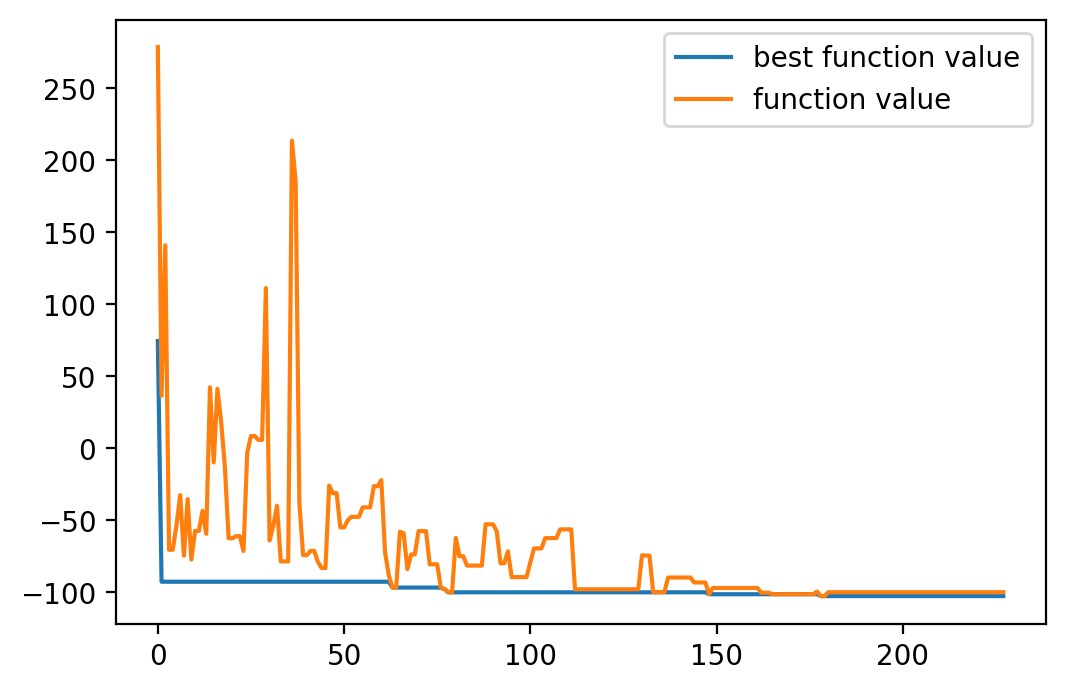

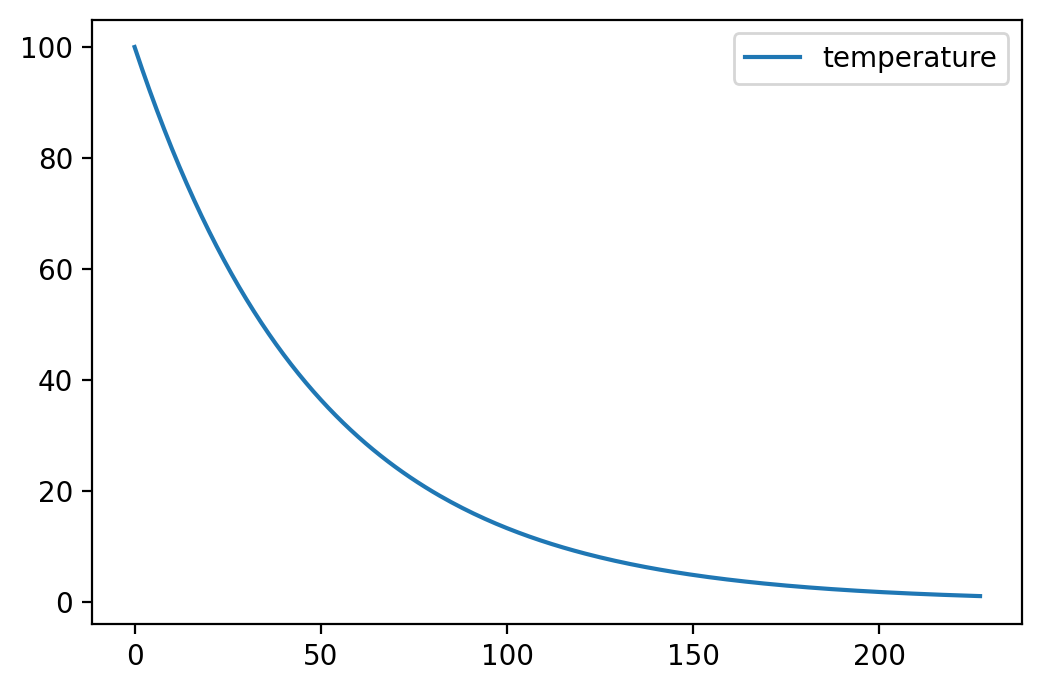

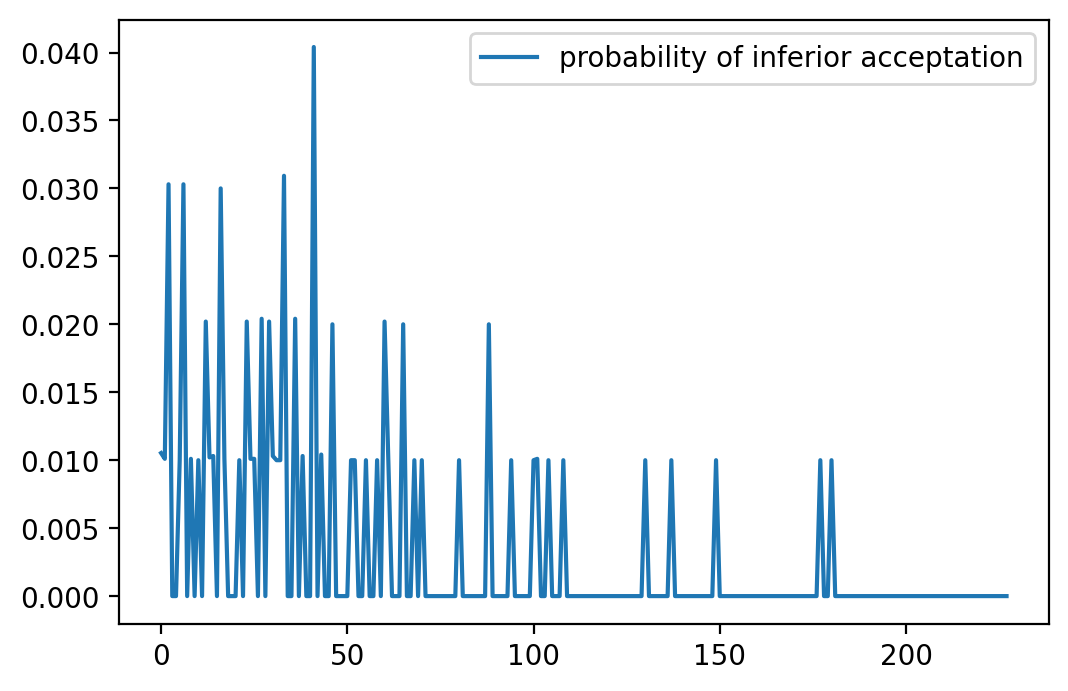

In [3]:
if __name__ == '__main__':

    # SA = SimulatedAnnealing(var_num=10, var_min=-1000, var_max=1000,
    #                         temp_init=100, temp_final=1, markov=100, alpha=0.98, lr=0.5)
    SA = SimulatedAnnealing(var_num=2, var_min=-500, var_max=500,
                            temp_init=100, temp_final=1, markov=100, alpha=0.98, lr=0.4)
    SA.solve(123456789101112)

    print('Solution:', SA.X_best)
    print('value:', SA.fx_best)

    plt.figure(dpi=200)
    plt.plot(SA.fx_best_, label='best function value')
    plt.plot(SA.fx_, label='function value')
    plt.legend()
    plt.figure(dpi=200)
    plt.plot(SA.temp_, label='temperature')
    plt.legend()
    plt.figure(dpi=200)
    plt.plot(SA.P_inferior_acc_, label='probability of inferior acceptation')
    plt.legend()
    plt.show()